---
# 레저용품 EDA
---

## 0. 데이터 로드 & 전처리

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import matplotlib
from numpy import inf

matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline

In [2]:
offline = pd.read_csv("../data/original_data/processed_data/CARD_SPENDING_RESIDENT_KOR.csv")
online  = pd.read_excel("../data/original_data/raw_data/05_물류데이터(CJ올리브네트웍스)/2020 빅콘테스트_CJ올리브네트웍스_제공DB.xlsx")

In [3]:
# 요일 계산
weekdays = {0:'월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}
offline['STD_DD'] = pd.to_datetime(offline.STD_DD, format='%Y%m%d')
online['DL_YMD'] = pd.to_datetime(online['DL_YMD'], format='%y%m%d')
offline['WEEKDAY'] = offline.STD_DD.dt.dayofweek.apply(lambda x : '_'.join([str(x), weekdays.get(x)]))
online['WEEKDAY'] = online.DL_YMD.dt.dayofweek.apply(lambda x : '_'.join([str(x), weekdays.get(x)]))

In [4]:
# 년, 월, 년+월 추출
online['YEAR']  = online['DL_YMD'].dt.year
online['MONTH'] = online['DL_YMD'].dt.month
online['YEAR_MONTH'] = online['YEAR']*100 + online['MONTH']

offline['YEAR']  = offline['STD_DD'].dt.year
offline['MONTH'] = offline['STD_DD'].dt.month
offline['YEAR_MONTH'] = offline['YEAR']*100 + offline['MONTH']

In [5]:
# 주차 계산
offline['WEEK_NUM'] = offline['STD_DD'].dt.weekofyear
online['WEEK_NUM']  = online['DL_YMD'].dt.weekofyear

## 1. 전년 동월 대비 비교

In [6]:
def graph_by_year_month_offline(category_name):
    # 카테고리에 속하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # YEAR, MONTH로 묶고 AMT, CNT 합 구하기
    category_df = category_df.groupby(['YEAR', 'MONTH'])[['USE_AMT', 'USE_CNT']].sum().reset_index()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    sns.barplot(x=category_df['MONTH'], y=category_df['USE_CNT'], hue='YEAR', data=category_df, ax=axes[0])
    sns.barplot(x=category_df['MONTH'], y=category_df['USE_AMT'], hue='YEAR', data=category_df, ax=axes[1])
    axes[0].set_title(category_name + "의 월별 소비횟수")
    axes[1].set_title(category_name + "의 월별 소비금액")

In [7]:
def graph_by_year_month_online(category_name):
    plt.figure(figsize=(8, 5)) 
    # 카테고리에 속하는 데이터 뽑기
    category_df = online.query('DL_GD_LCLS_NM=="{}"'.format(category_name))
    # YEAR, MONTH로 묶고 AMT, CNT 합 구하기
    category_df = category_df.groupby(['YEAR', 'MONTH'])[['INVC_CONT']].sum().reset_index() 

    sns.barplot(x='MONTH', y='INVC_CONT', hue='YEAR', data=category_df)
    plt.title(category_name + " 송장건수")

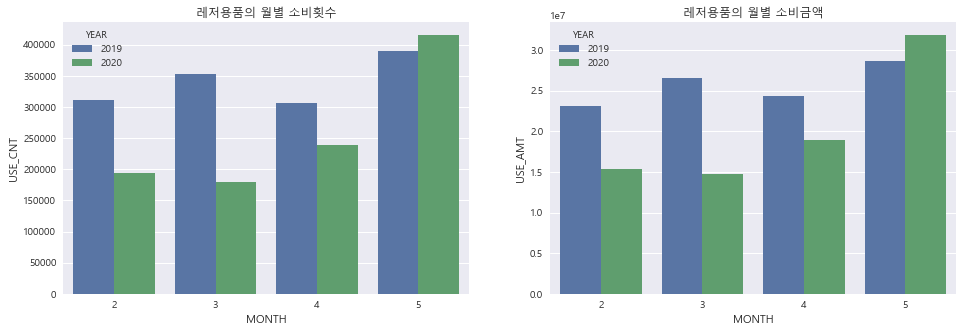

In [8]:
# 오프라인의 경우 2, 3, 4월에는 전년 대비 소비횟수나 소비금액 모두 낮다
# 5월에는 전년 대비 높은 소비횟수, 소비금액을 보인다.
graph_by_year_month_offline("레저용품")

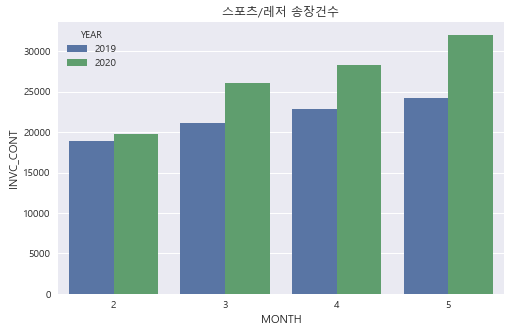

In [9]:
# 온라인에서 스포츠/레저 관련 소비는 2, 3, 4, 5월 모두 전년 대비 높은 수준이다
graph_by_year_month_online("스포츠/레저")

## 2. 오프라인 (카드)

In [10]:
def graph_by_year_month_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # YEAR_MONTH별로 CNT, AMT 합 구하기
    category_df = category_df.groupby(['YEAR_MONTH', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))
    sns.barplot(x='YEAR_MONTH', y='USE_CNT', hue=hue_column, data=category_df, ax=axes[0])
    sns.barplot(x='YEAR_MONTH', y='USE_AMT', hue=hue_column, data=category_df, ax=axes[1])
    axes[0].set_title(category_name + "의 {}별 소비횟수".format(hue_column))
    axes[1].set_title(category_name + "의 {}별 소비금액".format(hue_column))
    axes[0].legend(loc='lower right')
    axes[1].legend(loc='lower right')
    axes[0].axvline(x=3.5, color='r', linewidth=2, linestyle='--')
    axes[1].axvline(x=3.5, color='r', linewidth=2, linestyle='--')
    
    
def graph_by_month_number_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # 주차별로 CNT, AMT 합 구하기
    category_df = category_df.groupby(['YEAR', 'WEEK_NUM', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()
    df_2019 = category_df.query('YEAR==2019')
    df_2020 = category_df.query('YEAR==2020')
    
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 20))
    sns.barplot(x='WEEK_NUM', y='USE_CNT', hue=hue_column, data=df_2019, ax=axes[0])
    sns.barplot(x='WEEK_NUM', y='USE_CNT', hue=hue_column, data=df_2020, ax=axes[1])
    sns.barplot(x='WEEK_NUM', y='USE_AMT', hue=hue_column, data=df_2019, ax=axes[2])
    sns.barplot(x='WEEK_NUM', y='USE_AMT', hue=hue_column, data=df_2020, ax=axes[3])
    
    aggregate_columns = ['USE_CNT', 'USE_AMT']
    years = [2019, 2020]
    for i in [0, 1, 2, 3]:
        axes[i].set_title(category_name + "{}년의 {}별 {}".format(years[i%2], hue_column, aggregate_columns[i//2]))
        axes[i].legend(loc='lower right')
        axes[i].set_ylim([0, category_df[aggregate_columns[i//2]].max()*1.1])
        axes[i].axvline(x=2.5, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=6.5, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=14.5, color='g', linewidth=2, linestyle='--')
        axes[i].text(x=2.5, y=category_df[aggregate_columns[i//2]].max()*0.9, s="　코로나 확산기(8~11주)")
        axes[i].text(x=14.5, y=category_df[aggregate_columns[i//2]].max()*0.9, s="　재난지원금 지급주")


def graph_by_weekday_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # 년도 + 요일별로 CNT, AMT 합 구하기
    category_df = category_df.groupby(['YEAR', 'WEEKDAY', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()
    df_2019 = category_df.query('YEAR==2019')
    df_2020 = category_df.query('YEAR==2020')
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
    sns.barplot(x=hue_column, y='USE_CNT', hue='WEEKDAY', data=df_2019, ax=axes[0][0])
    sns.barplot(x=hue_column, y='USE_CNT', hue='WEEKDAY', data=df_2020, ax=axes[0][1])
    sns.barplot(x=hue_column, y='USE_AMT', hue='WEEKDAY', data=df_2019, ax=axes[1][0])
    sns.barplot(x=hue_column, y='USE_AMT', hue='WEEKDAY', data=df_2020, ax=axes[1][1])
    
    aggregate_columns = ['USE_CNT', 'USE_AMT']
    years = [2019, 2020]
    for i in [0, 1]:
        for j in [0, 1]:
            axes[i][j].set_ylim([0, df_2019[aggregate_columns[i]].max()*1.1])
            axes[i][j].set_title("{}년 요일별 {}".format(years[j], aggregate_columns[i]))
    
    
def graph_by_same_month_ratio_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # 동 내 YEAR_MONTH, HUE(성별, 연령) CNT, AMT 합 구하기
    category_df = category_df.groupby(['DONG_CD', 'YEAR_MONTH', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()

    result_df = pd.DataFrame()
    DONGs  = category_df['DONG_CD'].unique()
    LISTs  = category_df[hue_column].unique()

    for dong in DONGs:
        dong_temp = category_df.loc[category_df['DONG_CD']==dong, :]
        for select in LISTs:
            temp = dong_temp.loc[dong_temp[hue_column]==select, :]
            for year_month in [201902, 201903, 201904, 201905]:
                try:
                    year_2019_cnt, year_2019_amt = temp.loc[temp['YEAR_MONTH']==year_month, ['USE_CNT', 'USE_AMT']].values[0]
                    year_2020_cnt, year_2020_amt = temp.loc[temp['YEAR_MONTH']==year_month+100, ['USE_CNT', 'USE_AMT']].values[0]
                    # 전년 동월 대비 올해의 CNT 비율
                    # 전년 동월 대비 올해의 AMT 비율
                    result_df = result_df.append({   "dong":dong,
                                                     hue_column:select,
                                                     "month":round(year_month-201900, 0),
                                                     "cnt_ratio":year_2020_cnt/year_2019_cnt,
                                                     "amt_ratio":year_2020_amt/year_2019_amt}, ignore_index=True)
                except:
                    continue
                    #print(dong, age, year_month)
                    
    display(result_df[['cnt_ratio', 'amt_ratio']].describe())
    # 극단치 때문에 median 사용
    result_median_df = result_df.groupby(['month', hue_column])[['amt_ratio', 'cnt_ratio']].median().reset_index() 
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
    sns.boxplot(result_df['cnt_ratio'], ax=axes[0][0])
    sns.boxplot(result_df['amt_ratio'], ax=axes[0][1])
    sns.barplot(x='month', y='cnt_ratio', hue=hue_column, data=result_median_df, ax=axes[1][0])
    sns.barplot(x='month', y='amt_ratio', hue=hue_column, data=result_median_df, ax=axes[1][1])    

    axes[0][0].set_title("cnt_ratio BOXPLOT"); 
    axes[0][1].set_title("amt_ratio BOXPLOT")
    axes[1][0].legend(loc='lower right'); 
    axes[1][1].legend(loc='lower right')
    axes[1][0].axhline(y=1, color='r', linewidth=2, linestyle='--'); 
    axes[1][1].axhline(y=1, color='r', linewidth=2, linestyle='--')
    axes[1][0].set_title("2019년 대비 2020년 동월의 cnt 비율의 median")
    axes[1][1].set_title("2019년 대비 2020년 동월의 amt 비율의 median")
    
    
def graph_by_increase_rate_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # 동 내 YEAR_MONTH, HUE(성별, 연령) CNT, AMT 합 구하기
    category_df = category_df.groupby(['DONG_CD', 'YEAR_MONTH', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()

    result_df = pd.DataFrame()
    DONGs = category_df['DONG_CD'].unique()
    LISTs  = category_df[hue_column].unique()

    for dong in DONGs:
        dong_temp = category_df.loc[category_df['DONG_CD']==dong, :]
        for select in LISTs:
            temp = dong_temp.loc[dong_temp[hue_column]==select, :]
            try:
                year_2019 = temp.loc[temp['YEAR_MONTH']<202000, ['USE_CNT', 'USE_AMT']]
                year_2019_cnt = ((year_2019['USE_CNT'] - year_2019['USE_CNT'].shift(1)).dropna() / year_2019['USE_CNT'].shift(1).dropna()).values
                year_2019_amt = ((year_2019['USE_AMT'] - year_2019['USE_AMT'].shift(1)).dropna() / year_2019['USE_AMT'].shift(1).dropna()).values

                year_2020 = temp.loc[temp['YEAR_MONTH']>202000, ['USE_CNT', 'USE_AMT']]
                year_2020_cnt = ((year_2020['USE_CNT'] - year_2020['USE_CNT'].shift(1)).dropna() / year_2020['USE_CNT'].shift(1).dropna()).values
                year_2020_amt = ((year_2020['USE_AMT'] - year_2020['USE_AMT'].shift(1)).dropna() / year_2020['USE_AMT'].shift(1).dropna()).values
                
                # 2019년 2월 대비 3월 AMT/CNT 증가율 (3월 대비 4월, 4월 대비 5월도 구함)
                # 2020년 2월 대비 3월 AMT/CNT 증가율 (3월 대비 4월, 4월 대비 5월도 구함)
                for i, month in enumerate(['month_2_3', 'month_3_4', 'month_4_5']):
                    result_df = result_df.append({"year":2019,
                                                  "month":month,
                                                  "dong":dong,
                                                  hue_column:select,
                                                  "cnt_ratio":year_2019_cnt[i],
                                                  "amt_ratio":year_2019_amt[i]}, ignore_index=True)
                    result_df = result_df.append({"year":2020,
                                                  "month":month,
                                                  "dong":dong,
                                                  hue_column:select,
                                                  "cnt_ratio":year_2020_cnt[i],
                                                  "amt_ratio":year_2020_amt[i]}, ignore_index=True)
            except:
                continue
                #print(dong, age, year_month)
                
    result_df = result_df[['year', 'month', 'dong', hue_column, 'cnt_ratio', 'amt_ratio']]
    result_df['year'] = result_df['year'].map(int)
    temp = result_df.groupby(['year', 'month', hue_column])[['cnt_ratio', 'amt_ratio']].median().reset_index()

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    year_2019 = temp.query('year==2019')
    year_2020 = temp.query('year==2020')
    sns.lineplot(x='month', y='cnt_ratio', hue=hue_column, data=year_2019, ax=axes[0][0])
    sns.lineplot(x='month', y='cnt_ratio', hue=hue_column, data=year_2020, ax=axes[0][1])
    sns.lineplot(x='month', y='amt_ratio', hue=hue_column, data=year_2019, ax=axes[1][0])
    sns.lineplot(x='month', y='amt_ratio', hue=hue_column, data=year_2020, ax=axes[1][1])

    for row in [0, 1]:
        name = "cnt_ratio" if row == 0 else "amt_ratio"
        axes[row][0].set_title("2019년 " + name + " (전 월 대비 증가율)의 중위수")
        axes[row][1].set_title("2020년 " + name + " (전 월 대비 증가율)의 중위수")
        for col in [0, 1]:
            axes[row][col].axhline(y=0, color='r', linewidth=2, linestyle='--')
            axes[row][col].set_ylim([temp[name].min()-0.1, temp[name].max()+0.1])
            if hue_column == "age":
                axes[row][col].legend([20, 25, 30, 35, 40, 45, 50, 55, 60, 65], loc='upper left')
            else:
                axes[row][col].legend(['M', 'F'], loc='upper left')

### 1)연령별

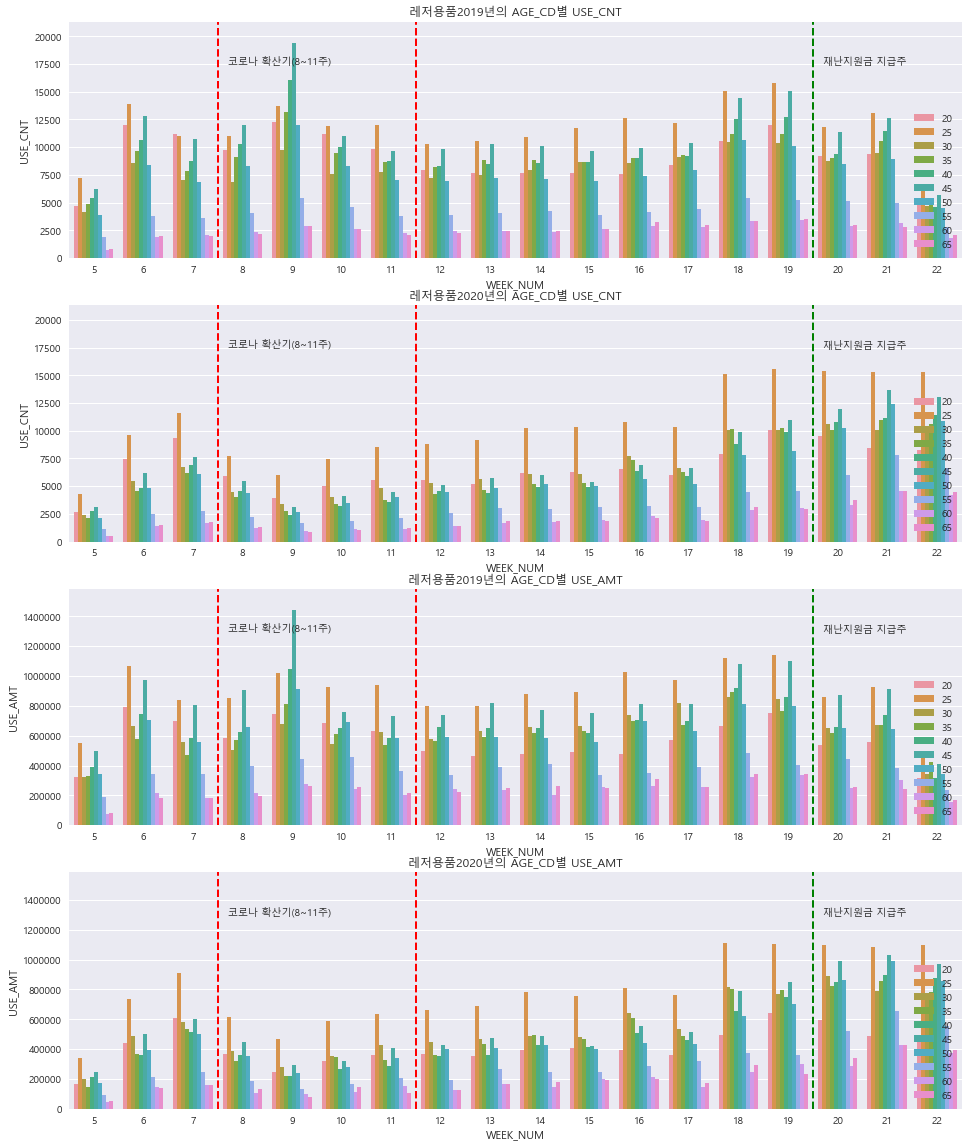

In [11]:
graph_by_month_number_offline("레저용품", "AGE_CD")

# 25~29세, 45~49세의 소비횟수/금액이 가장 많다.
# 60세 이상의 소비횟수/소비금액이 가장 낮다.

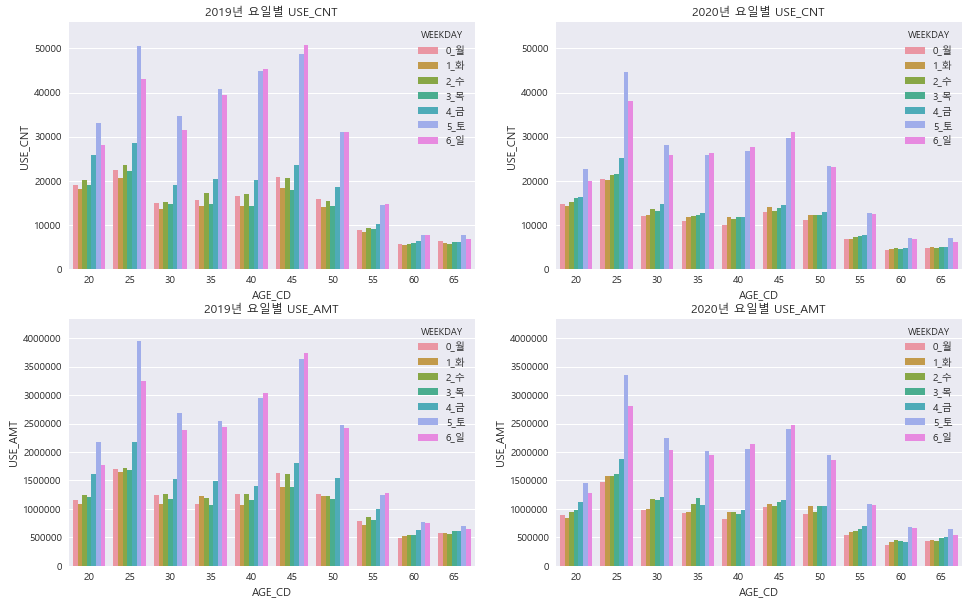

In [12]:
graph_by_weekday_offline("레저용품", "AGE_CD")

# 20~60세까지는 평일 대비 주말에 레저용품 구매건수/구매금액이 월등히 높다
# 60세 이상의 경우 평일과 주발이 크게 차이나지 않는다.

,cnt_ratio,amt_ratio
count,1889.000000,1889.000000
mean,0.983002,2.032301
std,2.302560,6.943434
min,0.017606,0.001363
25%,0.394231,0.341970
50%,0.648362,0.672269
75%,1.022472,1.348194
max,84.000000,136.735931


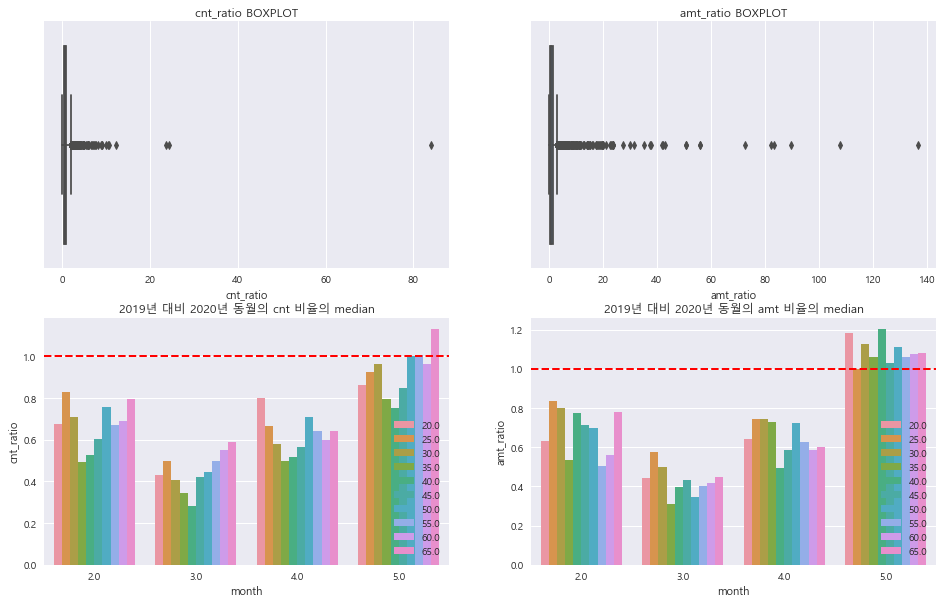

In [13]:
graph_by_same_month_ratio_offline("레저용품", "AGE_CD")

# 오프라인에서 전년 대비 올해 소비금액, 소비횟수를 월별로 구해보았다.
# 2, 3, 4월의 경우 전년 동월 대비 올해 AMT, CNT가 1보다 작았지만,
# 5월의 경우 전년 동월 대비 올해 AMT가 모두 1이상이었다.

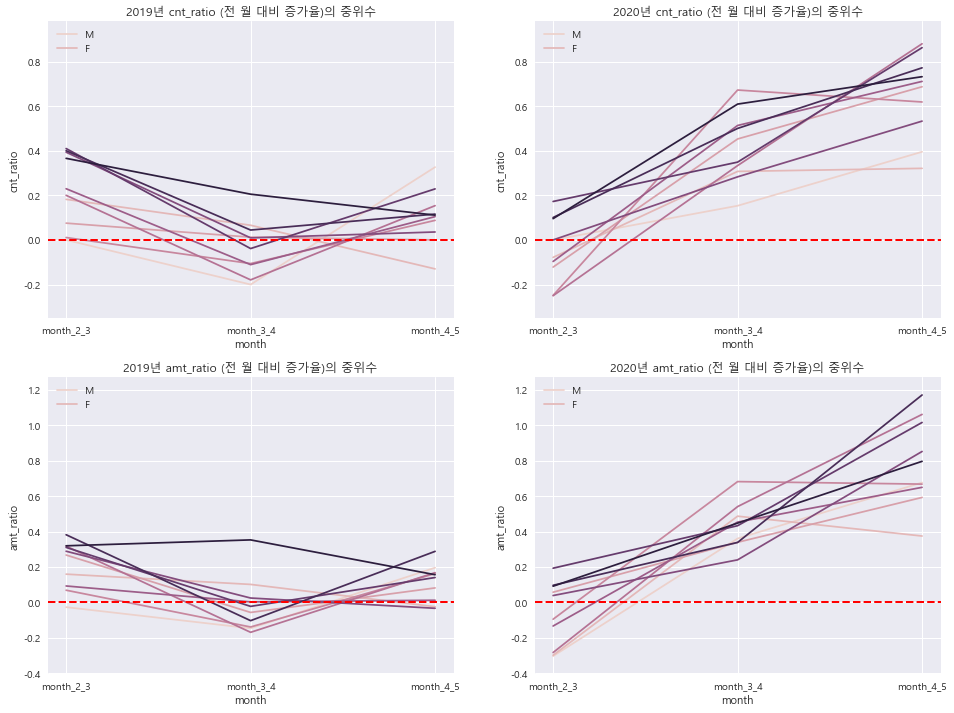

In [14]:
graph_by_increase_rate_offline("레저용품", "AGE_CD")

# 2019년에는 2월 대비 3월 증가하다가 3월 대비 4월은 감소, 4월 대비 5월은 다시 증가하는 경향을 보임
# 2020년에는 3월 대비 4월에 cnt 증가 / 4월 대비 5월에도 cnt 증가 (증가속도 빨라짐)
# 2020년에는 3월 대비 4월에 amt 증가 / 4월 대비 5월에도 amt 증가 (증가속도 빨라짐)

### 2) 성별

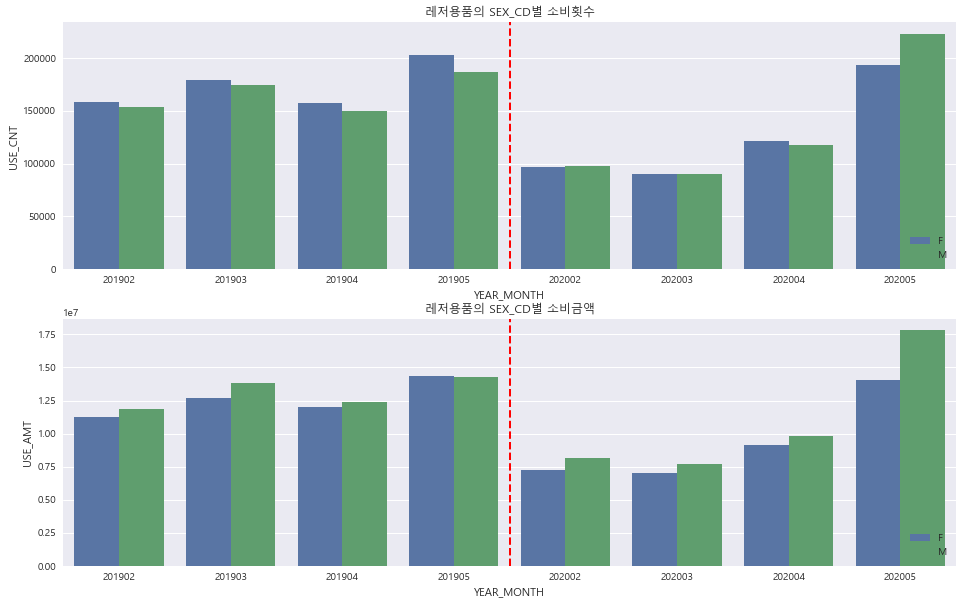

In [15]:
graph_by_year_month_offline("레저용품", "SEX_CD")

# 2019년에는 여성이 남성보다 소비횟수 높다. 2020년에도 지속되지만 2020년 5월에는 남성의 소비횟수가 여성 추월
# 2019년에는 남성이 여성보다 소비금액 높다. 2020년에도 이러한 경향이 지속

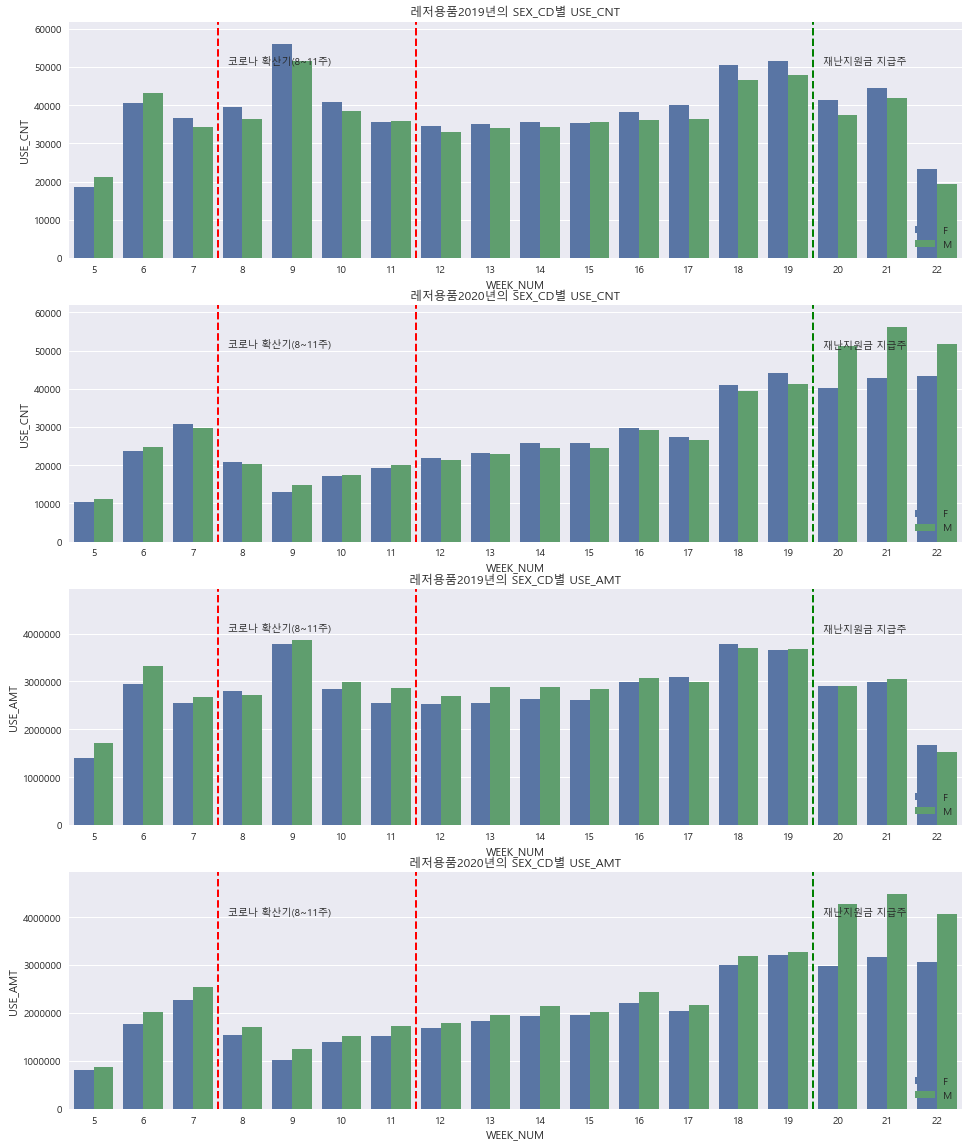

In [16]:
graph_by_month_number_offline("레저용품", "SEX_CD")

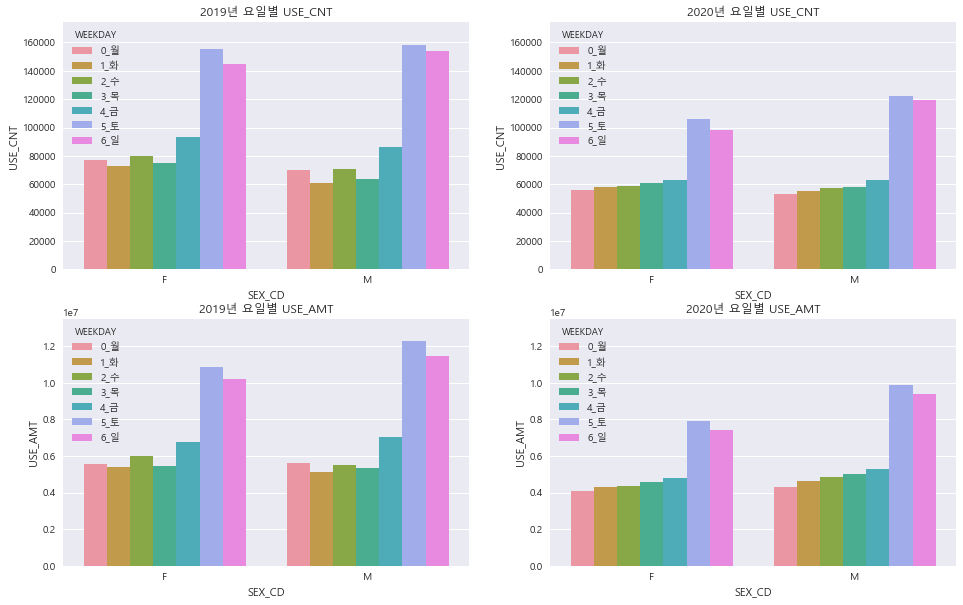

In [17]:
graph_by_weekday_offline("레저용품", "SEX_CD")

# 남성/여성 모두 평일 대비 주말에 레저용품 구매횟수/구매건수 높다

,cnt_ratio,amt_ratio
count,494.000000,494.000000
mean,0.911061,1.589674
std,1.235534,5.715312
min,0.014368,0.025399
25%,0.386138,0.425218
50%,0.619714,0.680637
75%,1.000000,1.234618
max,13.333333,111.000000


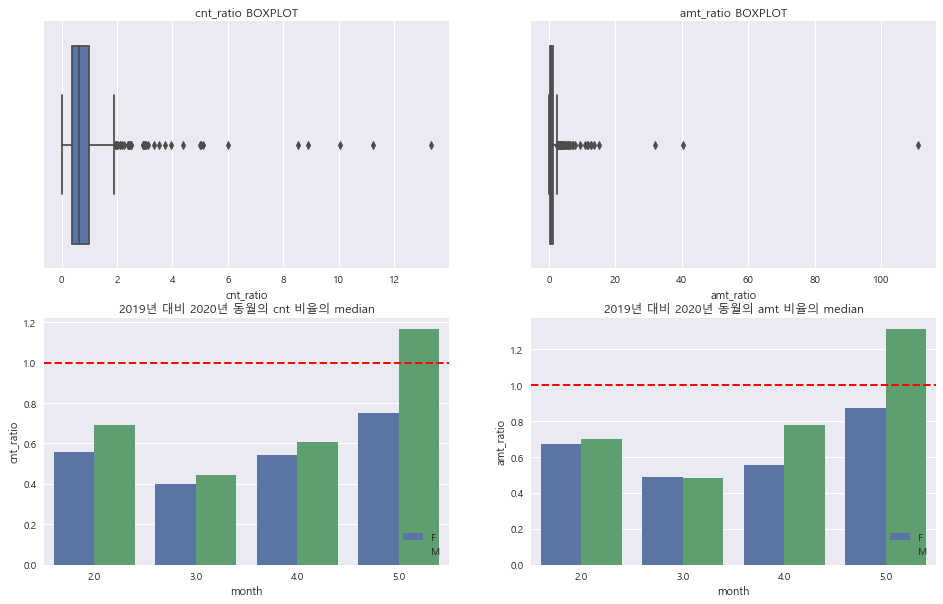

In [18]:
graph_by_same_month_ratio_offline("레저용품", "SEX_CD")

# 2, 3, 4월은 모두 전년 동월 대비 AMT, CNT가 낮은 수준
# 하지만 5월의 경우 남성은 AMT, CNT가 1이상 (여성은 1미만) -> 5월에 남성에게서 레저용품 구매횟수/구매건수 증가

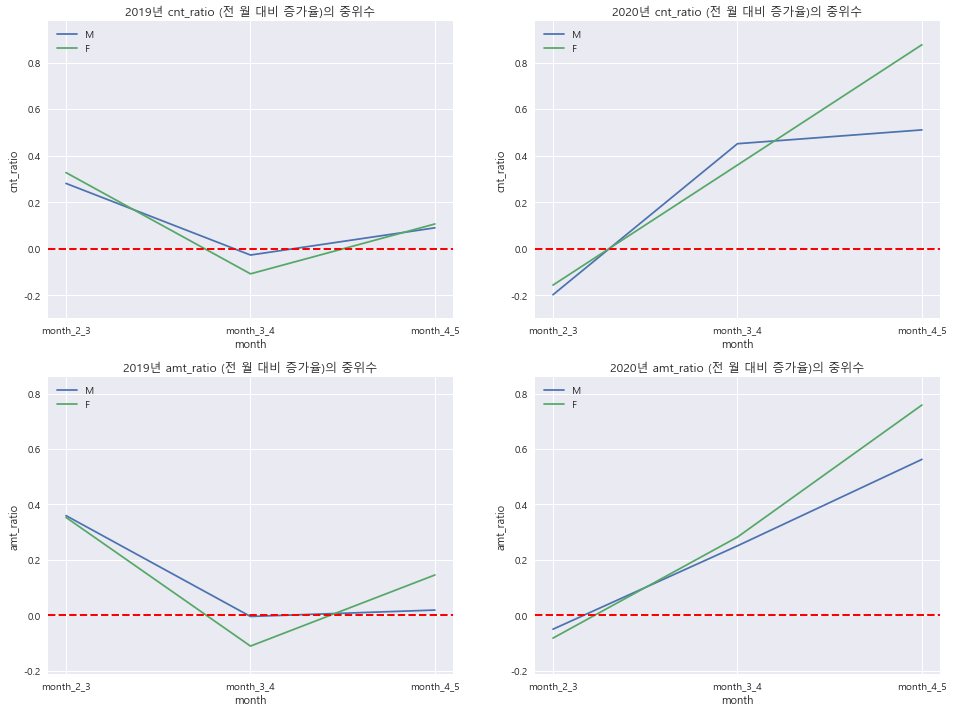

In [19]:
graph_by_increase_rate_offline("레저용품", "SEX_CD")

# 2019 : 2월 대비 3월 증가, 3월 대비 4월 감소, 4월 대비 5월 증가
# 2020 : 2월 대비 3월 감소, 3월 대비 4월 증가, 4월 대비 5월 증가

## 3. 온라인 (물류)

In [20]:
def graph_by_year_month_weekday_online(category_name):
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    category_df1 = online.groupby(['DL_GD_LCLS_NM', 'YEAR', 'MONTH'])[['INVC_CONT']].sum().reset_index()
    category_df1 = category_df1.query('DL_GD_LCLS_NM=="{}"'.format(category_name))
    
    category_df2 = online.groupby(['DL_GD_LCLS_NM', 'YEAR', 'WEEKDAY'])[['INVC_CONT']].sum().reset_index()
    category_df2 = category_df2.query('DL_GD_LCLS_NM=="{}"'.format(category_name))

    sns.barplot(x='MONTH',   y='INVC_CONT', hue='YEAR', data=category_df1, ax=axes[0])
    sns.barplot(x='WEEKDAY', y='INVC_CONT', hue='YEAR', data=category_df2, ax=axes[1])
    axes[0].set_title(category_name + " 송장건수")
    axes[1].set_title(category_name + " 송장건수")
    
def graph_by_same_month_ratio_online(category_name):    
    category_df = online.loc[online['DL_GD_LCLS_NM']==category_name, :]
    category_df = category_df.groupby(['HDNG_NM', 'YEAR_MONTH'])[['INVC_CONT']].sum().reset_index()

    result_df = pd.DataFrame()
    DONGs = category_df['HDNG_NM'].unique()

    for dong in DONGs:
        temp = category_df.loc[category_df['HDNG_NM']==dong, :]
        for year_month in [201902, 201903, 201904, 201905]:
            try:
                year_2019 = temp.loc[temp['YEAR_MONTH']==year_month, ['INVC_CONT']].values[0][0]
                year_2020 = temp.loc[temp['YEAR_MONTH']==year_month+100, ['INVC_CONT']].values[0][0]
                result_df = result_df.append({   "dong":dong,
                                                 "month":round(year_month-201900, 0),
                                                 "invc_ratio":year_2020/year_2019}, ignore_index=True)
            except:
                continue
                #print(dong, age, year_month)

    display(result_df[['invc_ratio']].describe())
    result_median_df = result_df.groupby(['month'])[['invc_ratio']].median().reset_index() # 극단치 때문에 median 사용

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))
    sns.boxplot(result_df['invc_ratio'], ax=axes[0])
    sns.barplot(x='month', y='invc_ratio', data=result_median_df, ax=axes[1])

    axes[0].set_title("cnt_ratio BOXPLOT")
    axes[1].set_title("2019년 대비 2020년 동월의 송장건수 비율의 median")
    axes[1].axhline(y=1, color='r', linewidth=2, linestyle='--')


def graph_by_increase_rate_online(category_name):
    category_df = online.loc[online['DL_GD_LCLS_NM']==category_name, :]
    category_df = category_df.groupby(['HDNG_NM', 'YEAR_MONTH'])[['INVC_CONT']].sum().reset_index()

    result_df = pd.DataFrame()
    DONGs = category_df['HDNG_NM'].unique()

    for dong in DONGs:
        temp = category_df.loc[category_df['HDNG_NM']==dong, :]
        try:
            year_2019 = temp.loc[temp['YEAR_MONTH']<202000, ['INVC_CONT']]
            year_2019 = ((year_2019['INVC_CONT'] - year_2019['INVC_CONT'].shift(1)).dropna() / year_2019['INVC_CONT'].shift(1).dropna()).values

            year_2020 = temp.loc[temp['YEAR_MONTH']>202000, ['INVC_CONT']]
            year_2020 = ((year_2020['INVC_CONT'] - year_2020['INVC_CONT'].shift(1)).dropna() / year_2020['INVC_CONT'].shift(1).dropna()).values

            for i, month in enumerate(['month_2_3', 'month_3_4', 'month_4_5']):
                result_df = result_df.append({  "year":2019,
                                                "month":month,
                                                "dong":dong,
                                                "invc_ratio":year_2019[i]}, ignore_index=True)

                result_df = result_df.append({  "year":2020,
                                                "month":month,
                                                "dong":dong,
                                                "invc_ratio":year_2020[i]}, ignore_index=True)
        except:
            continue
            #print(dong, age, year_month)

    result_df = result_df[['year', 'month', 'dong','invc_ratio']]
    result_df['year'] = result_df['year'].map(int)
    temp = result_df.groupby(['year', 'month'])[['invc_ratio']].median().reset_index()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    year_2019 = temp.query('year==2019')
    year_2020 = temp.query('year==2020')
    sns.lineplot(x='month', y='invc_ratio', data=year_2019, ax=axes[0])
    sns.lineplot(x='month', y='invc_ratio', data=year_2020, ax=axes[1])

    axes[0].set_title("2019년 송장건수 (전 월 대비 증가율)의 중위수")
    axes[1].set_title("2020년 송장건수 (전 월 대비 증가율)의 중위수")
    axes[0].axhline(y=0, color='r', linewidth=2, linestyle='--')
    axes[1].axhline(y=0, color='r', linewidth=2, linestyle='--')
    axes[0].set_ylim([temp['invc_ratio'].min()-0.1, temp['invc_ratio'].max()+0.1])
    axes[1].set_ylim([temp['invc_ratio'].min()-0.1, temp['invc_ratio'].max()+0.1])


In [21]:
online_category_name = "스포츠/레저"

,invc_ratio
count,276.000000
mean,1.245173
std,0.226993
min,0.682131
25%,1.050678
50%,1.271551
75%,1.393756
max,1.944134


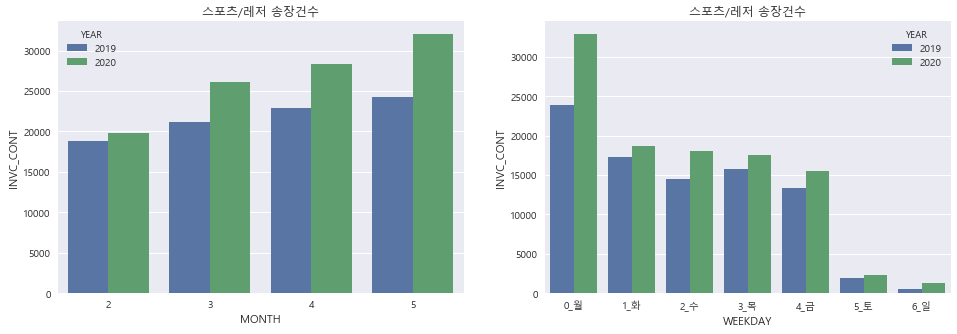

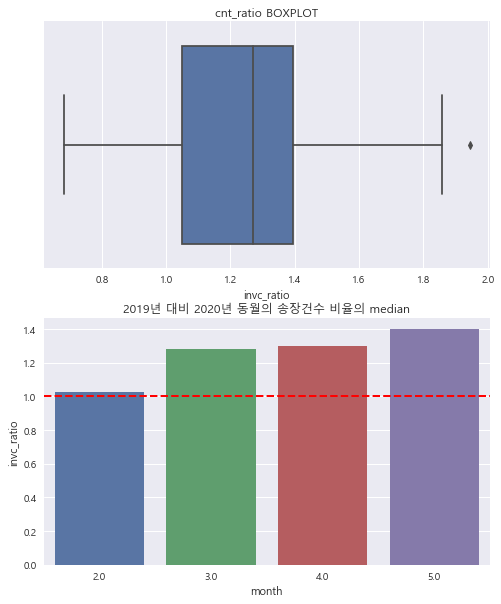

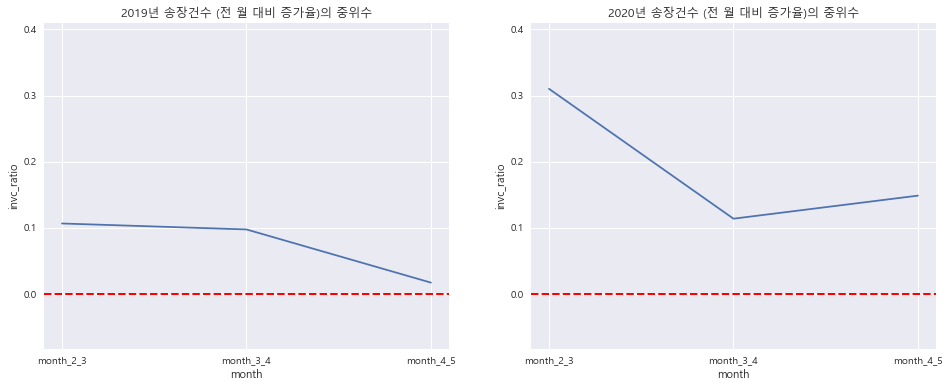

In [22]:
graph_by_year_month_weekday_online(online_category_name)
graph_by_same_month_ratio_online(online_category_name)
graph_by_increase_rate_online(online_category_name)


# 2019년이나 2020년이나 2, 3, 4, 5월 꾸준히 증가하는 추세이다.
# 월요일날 송장건수가 가장 많았다 (아마 주말에 구매하면 송장 등록되는 시점이 월요일이라서 그런 것 같다)
# 2019년 대비 2020년 동월의 송장건수 모두 1 이상 (2, 3, 4, 5월)
# 2월 대비 3월 증가율 : 2019년 10% < 2020년 30%
# 3월 대비 4월 증가율 : 2019년, 2020년 모두 10%으로 비슷
# 4월 대비 5월 증가율 : 2019년 2% < 15%

## 4. 코로나 신규 확진자수 추이
- 코로나 신규 확진자수가 최고점을 찍었던 정보를 활용해 기간을 분류하고, EDA를 진행해나가려 한다.

In [23]:
def graph_corona_time_plot(link):
    corona = pd.read_csv(link)
    corona.fillna(0, inplace=True)
    corona['합'] = corona.drop(['날짜', '검역 누적'], axis=1).sum(axis=1)
    corona['합'] = corona['합'] - corona['합'].shift(1)
    corona['합'].fillna(0, inplace=True)
    corona = corona.set_index("날짜")
    
    max_date = corona.index[corona['합'].argmax()]
    print(max_date)
    max_date_num_week = pd.to_datetime(max_date).weekofyear
    print(max_date_num_week)

    ax = corona[['합']].plot(figsize=(16, 6))
    ax.axvline(x=corona['합'].argmax(), color='r', linewidth=2, linestyle='--')
    plt.text(x=corona['합'].argmax(), 
             y=corona['합'].max()*0.9, 
             s='　코로나 신규 확진자수 MAX \n　{} - {}주차'.format(max_date, max_date_num_week), 
             fontsize=14)
    plt.title("코로나 신규확진자수 (한국)", fontsize=14)
    plt.show()

2020-03-01 00:00:00
9


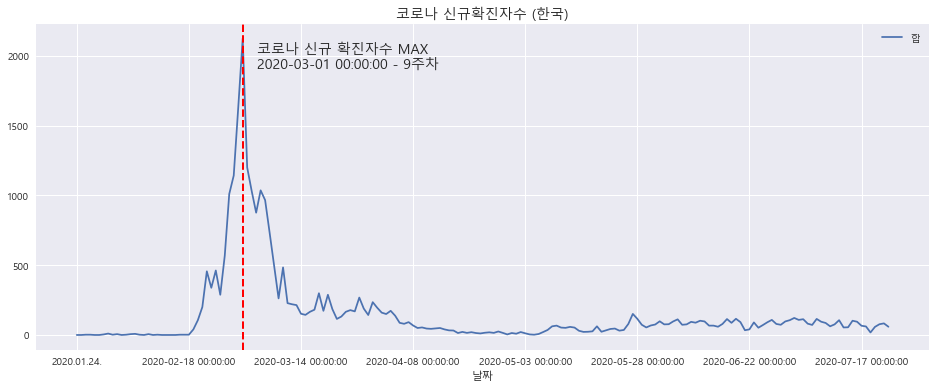

In [24]:
graph_corona_time_plot("../data/external_data/processed_data/covid19_누적확진자.csv")

## 5. 주차별 소비

In [25]:
def graph_by_weeknum_online(category_name, aggregate_column):
    week_df = online.groupby(['DL_GD_LCLS_NM', 'CTPV_NM', 'CTGG_NM', 'YEAR', 'WEEK_NUM'])[[aggregate_column]].mean().reset_index()
    week_df = week_df.groupby(['DL_GD_LCLS_NM', 'YEAR', 'WEEK_NUM'])[[aggregate_column]].sum().reset_index()
    week_df = week_df.loc[week_df['DL_GD_LCLS_NM']==category_name, :]

    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]

    plt.figure(figsize=(16, 5))
    ax = sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue='YEAR', data=week_df, palette="Set2")
    ax.set_xticks([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
    ax.legend([2019, 2020])
    ax.axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
    ax.axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
    ax.set_ylim([0, week_df[aggregate_column].max()*1.1])
    ax.text(x=max_date_num_week, 
         y=week_df.query('YEAR==2020')[aggregate_column].min(), 
         s='　코로나 신규 확진자수 최고\n　(2020.03.01)',
         fontsize=12)
    ax.text(x=disaster_support_date_num_week, 
         y=week_df.query('YEAR==2020')[aggregate_column].min(), 
         s='　재난지원금\n　(2020.05.13)',
         fontsize=12)
    ax.set_title("주차별 {} {}".format(category_name, aggregate_column.upper()), fontsize=12)

In [26]:
def graph_by_weeknum_offline(category_name, aggregate_column):
    # 지역별 주별 평균을 구하고 -> 이것을 업종별로 합해서 그 업종 추이를 보고자 하였다
    week_df = offline.groupby(['MCT_CAT_CD', 'GU_CD', 'DONG_CD', 'YEAR', 'WEEK_NUM', 'SEX_CD', 'AGE_CD'])[[aggregate_column]].mean().reset_index()
    week_df = week_df.groupby(['MCT_CAT_CD', 'YEAR', 'WEEK_NUM'])[[aggregate_column]].sum().reset_index()
    week_df = week_df.loc[week_df['MCT_CAT_CD']==category_name, :]
    
    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]

    plt.figure(figsize=(16, 5))
    ax = sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue='YEAR', data=week_df, palette="Set2")
    ax.set_xticks([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
    ax.legend([2019, 2020])
    ax.axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
    ax.axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
    ax.set_ylim([0, week_df[aggregate_column].max()*1.1])
    ax.text(x=max_date_num_week, 
         y=week_df.query('YEAR==2020')[aggregate_column].min(), 
         s='　코로나 신규 확진자수 최고\n　(2020.03.01)',
         fontsize=12)
    ax.text(x=disaster_support_date_num_week, 
         y=week_df.query('YEAR==2020')[aggregate_column].min(), 
         s='　재난지원금\n　(2020.05.13)',
         fontsize=12)
    ax.set_title("주차별 {} {}".format(category_name, aggregate_column.upper()), fontsize=12)
    
    
def graph_by_weeknum_with_hue_offline(category_name, aggregate_column, hue_column):
    week_df = offline.groupby(['MCT_CAT_CD', 'GU_CD', 'DONG_CD', 'YEAR', 'WEEK_NUM', 'SEX_CD', 'AGE_CD'])[[aggregate_column]].mean().reset_index()
    week_df = week_df.groupby(['MCT_CAT_CD', 'YEAR', 'WEEK_NUM', hue_column])[[aggregate_column]].sum().reset_index()
    week_df = week_df.loc[week_df['MCT_CAT_CD']==category_name, :]
    
    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]

    year_2019_df = week_df.loc[week_df['YEAR']==2019, :]
    year_2020_df = week_df.loc[week_df['YEAR']==2020, :]

    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]
    hue_columns = list(set(week_df[hue_column]))
    hue_columns.sort()
    len_rows = len(set(week_df[hue_column]))

    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue=hue_column, data=year_2019_df, palette="Set2", ax=axes[0])
    sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue=hue_column, data=year_2020_df, palette="Set2", ax=axes[1])
    for i in [0, 1]:
        year = 2019 if i==0 else 2020
        axes[i].set_ylim([0, week_df[aggregate_column].max()*1.1])
        axes[i].legend(loc='lower left')
        axes[i].set_xticks(list(set(week_df['WEEK_NUM'])))
        axes[i].axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
        axes[i].set_title("{}년도".format(year))

    fig, axes = plt.subplots(nrows=len_rows, figsize=(16, 5*len_rows))
    for i, select in enumerate(hue_columns):
        temp_2019 = year_2019_df.loc[year_2019_df[hue_column]==select, :]
        temp_2020 = year_2020_df.loc[year_2020_df[hue_column]==select, :]

        sns.lineplot(x='WEEK_NUM', y=aggregate_column, data=temp_2019, ax=axes[i], palette='Set2')
        sns.lineplot(x='WEEK_NUM', y=aggregate_column, data=temp_2020, ax=axes[i], palette='Set2')
        axes[i].set_ylim(0, max([temp_2019[aggregate_column].max(), temp_2020[aggregate_column].max()])*1.1)
        axes[i].set_xticks(list(set(week_df['WEEK_NUM'])))
        axes[i].legend([2019, 2020], loc='upper left')
        axes[i].axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
        axes[i].set_title(select)
        axes[i].text(x=max_date_num_week, 
                     y=min([temp_2019[aggregate_column].min(), temp_2020[aggregate_column].min()]), 
                     s='　코로나 신규 확진자수 최고\n　(2020.03.01)',
                     fontsize=12)
        axes[i].text(x=disaster_support_date_num_week, 
                     y=min([temp_2019[aggregate_column].min(), temp_2020[aggregate_column].min()]), 
                     s='　재난지원금\n　(2020.05.13)',
                     fontsize=12)

    plt.show()

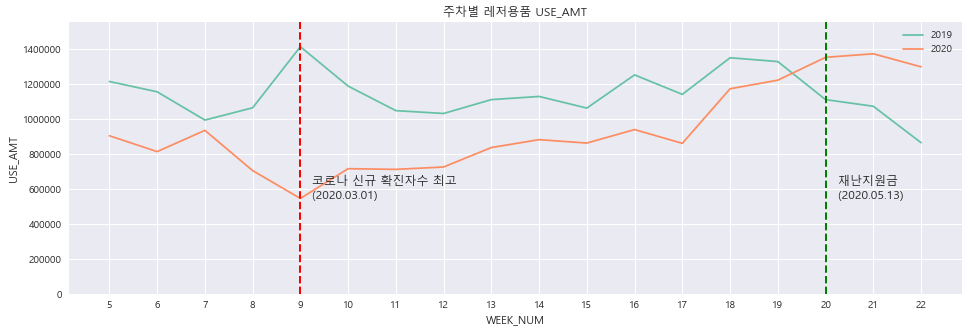

In [27]:
graph_by_weeknum_offline("레저용품", "USE_AMT")

# 코로나로 소비횟수 감소하다가, 
# 신규 확진자수 최고 찍고서는 꾸준히 소비금액 증가하는 추세이다

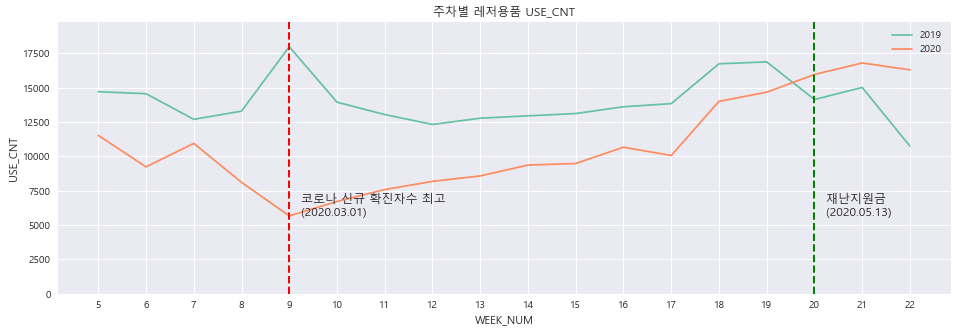

In [28]:
graph_by_weeknum_offline("레저용품", "USE_CNT")

# 코로나로 소비횟수 감소하다가, 
# 신규 확진자수 최고 찍고서는 꾸준히 소비횟수 증가하는 추세이다

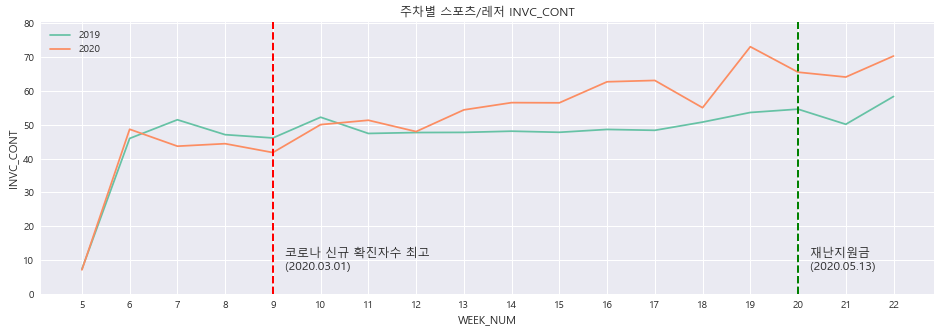

In [29]:
graph_by_weeknum_online("스포츠/레저", "INVC_CONT")

# 코로나로 소비횟수가 거의 감소하지 않았으며,
# 신규 확진자수 최고 찍고서는 작년보다 가파르게 송장건수 증가한다.

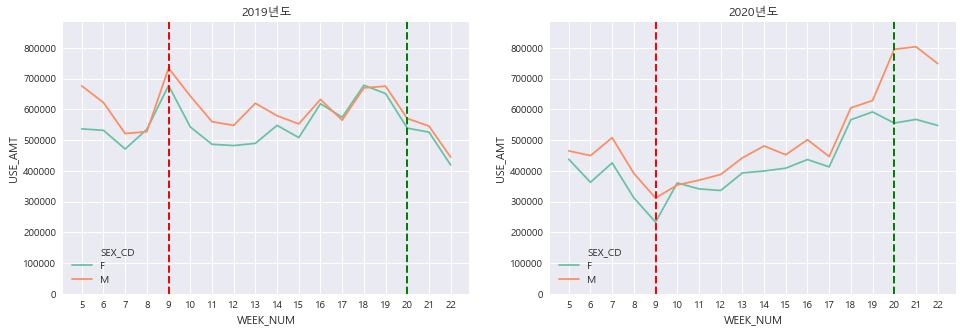

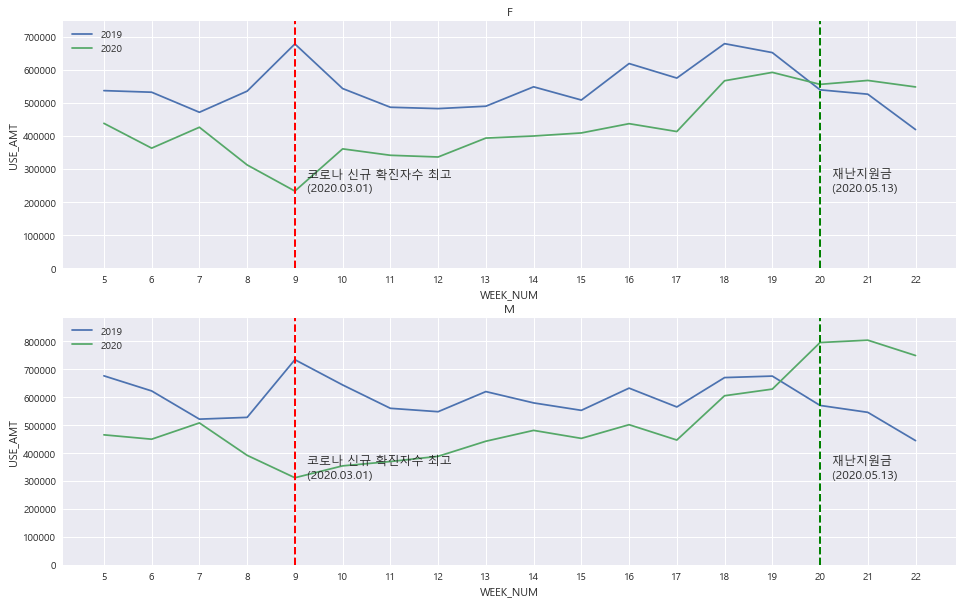

In [30]:
graph_by_weeknum_with_hue_offline("레저용품", "USE_AMT", "SEX_CD")

# 2020년에 여성 대비 남성에게서 소비금액 증가가 더 크게 나타났다.
# 또한 모든 연령대에서 코로나 이후 소비금액이 증가하는 패턴이 보인다.

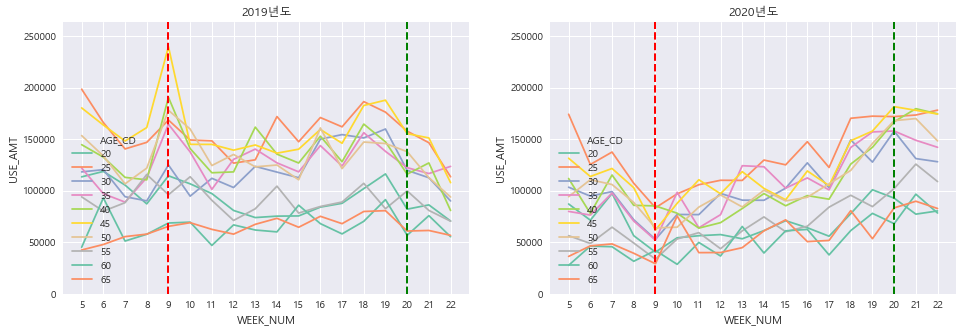

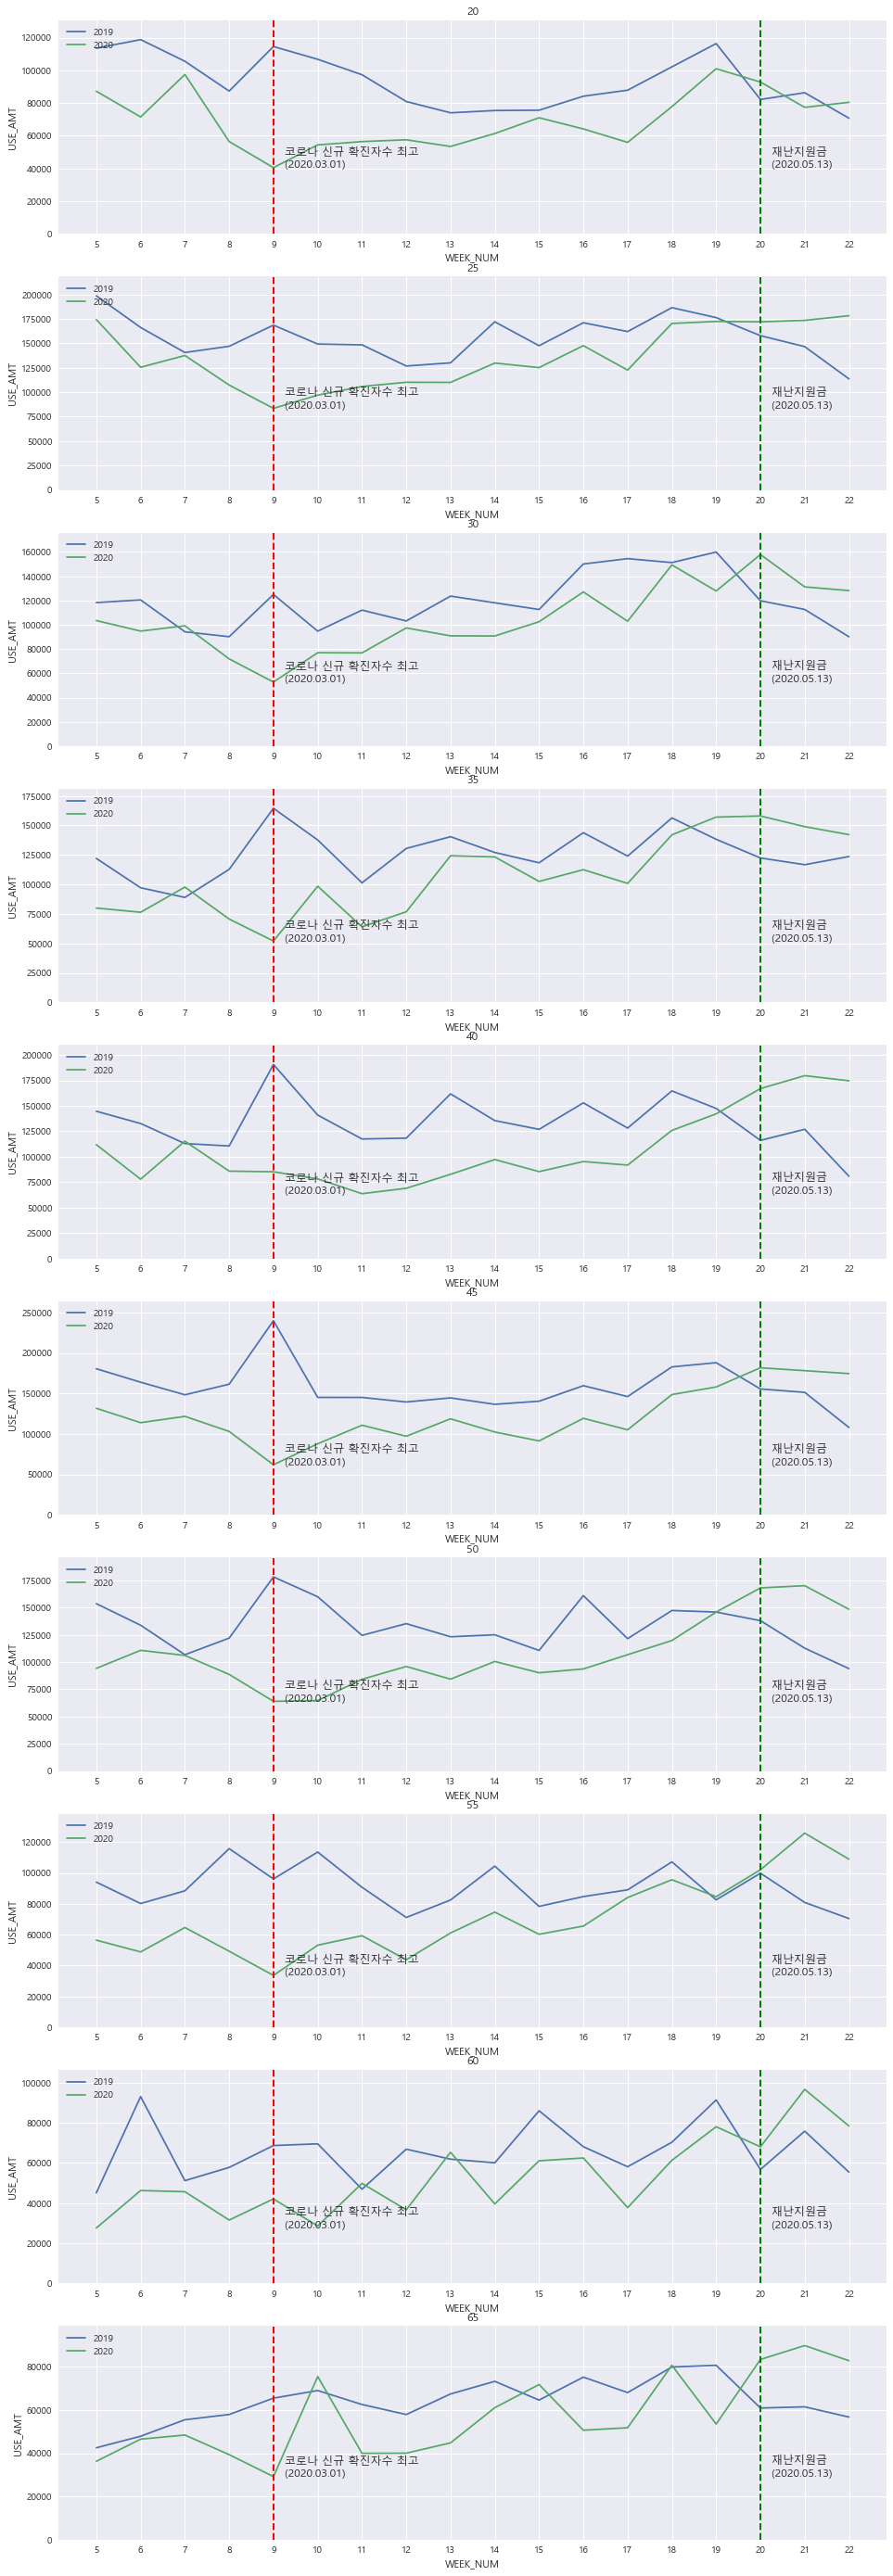

In [31]:
graph_by_weeknum_with_hue_offline("레저용품", "USE_AMT", "AGE_CD")

## 6. 지역별

### 1) weekofyear에 대해서 평균 -> 2019년 대비 2020년 값
- 동일한 weekofyear에 대해서 작년 대비 올해의 값 -> 지역적 특색 찾을 수 있지 않을까 하는 생각에서 시도

In [32]:
def graph_by_region_ratio(dataframe, category_name, category_column, gu_column, dong_column, aggregate_column, vmin=-1, vmax=2):
    # 카테고리 + 구 + 동 + 년도 + weekofyear에 대해서 평균
    groupby = dataframe.groupby([category_column, gu_column, dong_column, 'YEAR', 'WEEK_NUM'])[[aggregate_column]].mean().reset_index()
    groupby = groupby.query('{}=="{}"'.format(category_column, category_name))
    
    # 2019년
    year_2019 = groupby.query('YEAR==2019')
    year_2019 = year_2019.pivot_table(values=aggregate_column, index=dong_column, columns='WEEK_NUM')
    year_2019.fillna(0, inplace=True)

    # 2020년
    year_2020 = groupby.query('YEAR==2020')
    year_2020 = year_2020.pivot_table(values=aggregate_column, index=dong_column, columns='WEEK_NUM')
    year_2020.fillna(0, inplace=True)
    
    # 동일한 weekofyear에 대해 작년 대비 올해의 비율
    # 결측치 -> 0으로
    # inf -> 0으로 (0/0때문에 나온 결과이므로)
    ratio_2020_2019 = (year_2020 / year_2019).fillna(0)
    ratio_2020_2019[ratio_2020_2019 == inf] = 0

    plt.figure(figsize=(16, 0.3*len(set(dataframe[dong_column]))))
    sns.heatmap(ratio_2020_2019, cmap='coolwarm', vmin = vmin, vmax = vmax, fmt='.2f', annot=True)

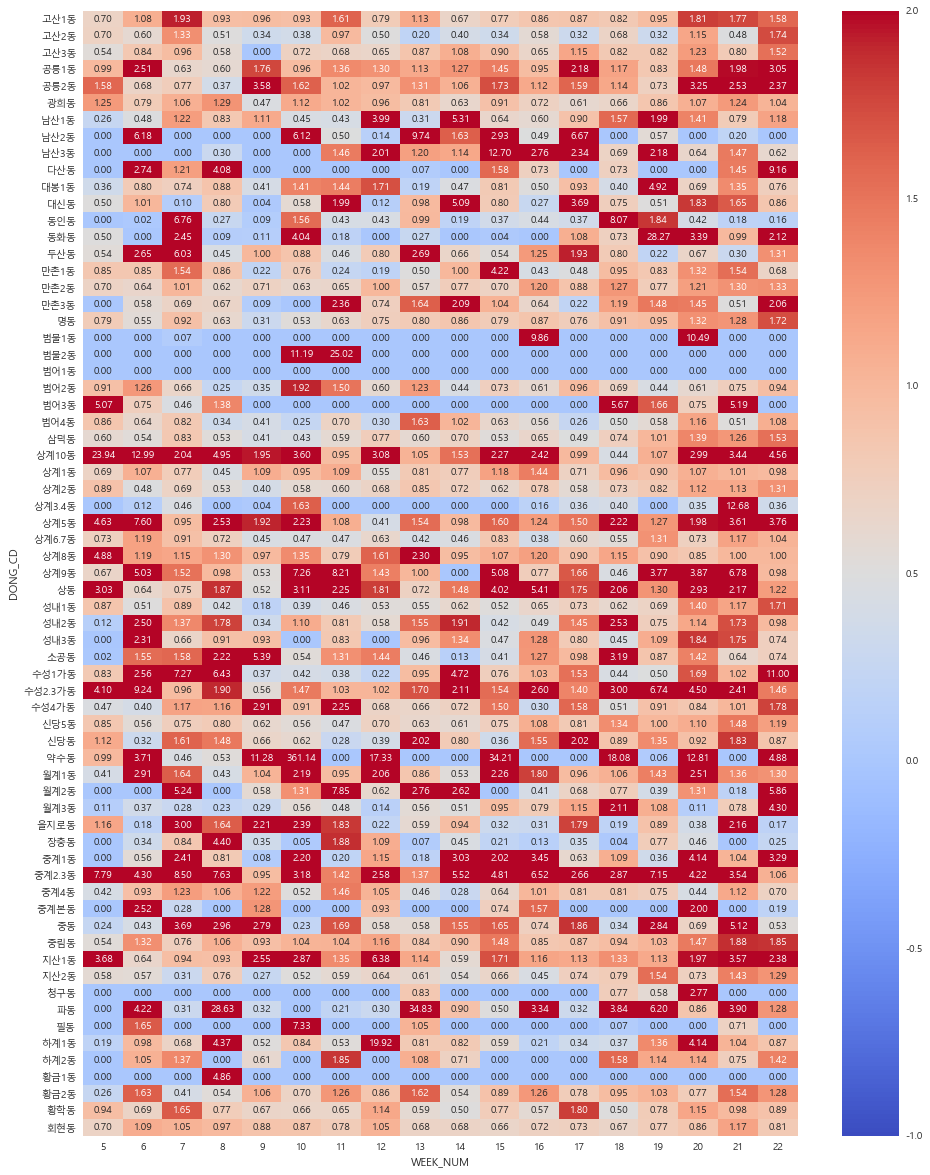

In [33]:
# 레저용품에 대한 소비가 작년 대비 가파르게 증가한 동이 존재한다.
# 동별마다 레저용품에 대한 소비증가 형태에 차이가 크다.
graph_by_region_ratio(offline, '레저용품', 'MCT_CAT_CD', 'GU_CD', 'DONG_CD', 'USE_AMT')

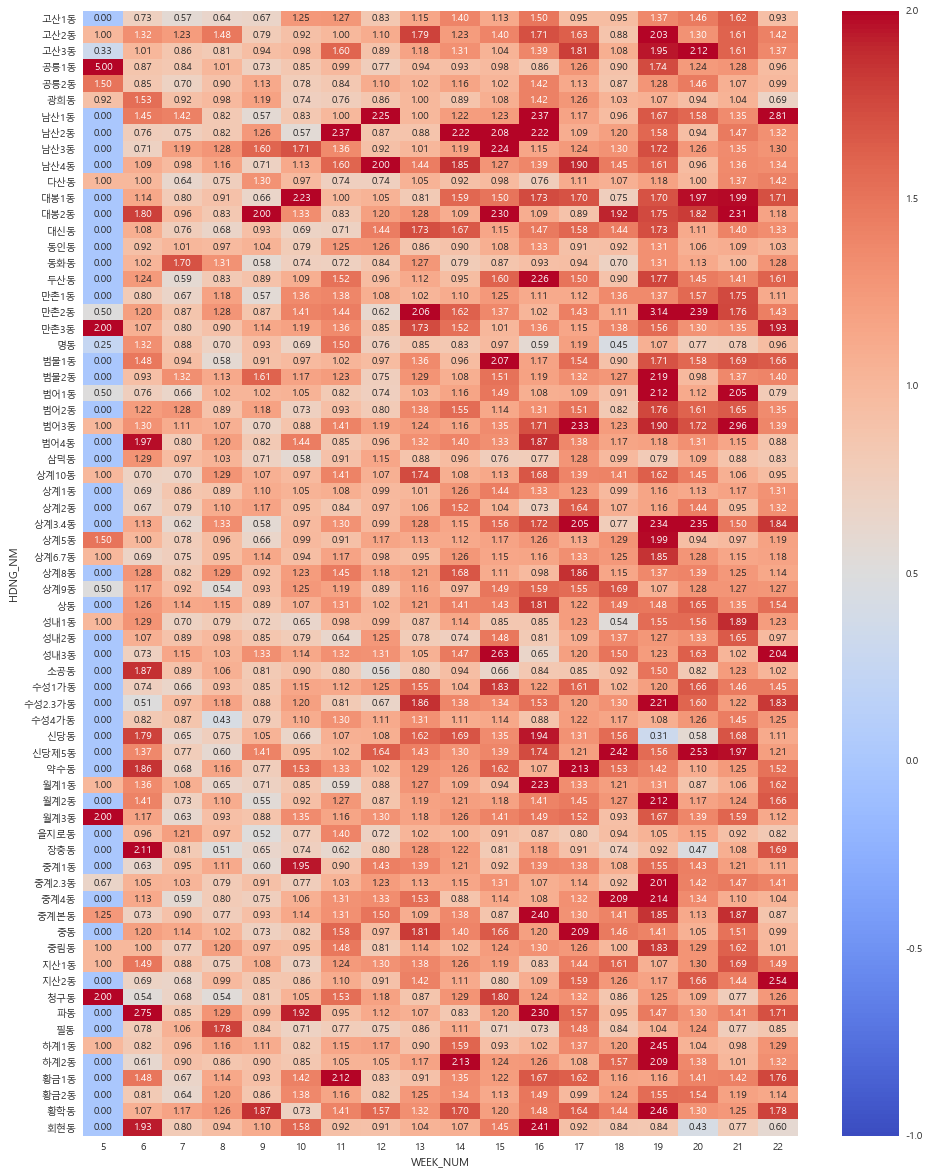

In [34]:
graph_by_region_ratio(online, "스포츠/레저", "DL_GD_LCLS_NM", "CTGG_NM", "HDNG_NM", "INVC_CONT")

## 7. 유동인구와의 관계

### 1) 카드 데이터와 결합 위해 유동인구 데이터 처리
- 유동인구에서의 연령과 카드에서의 연령 불일치 -> 맞추기 위한 작업

In [36]:
# load data
flow_201902 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201902.csv", sep='|')
flow_201903 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201903.csv", sep='|')
flow_201904 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201904.csv", sep='|')
flow_201905 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201905.csv", sep='|')
flow_202002 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202002.csv", sep='|')
flow_202003 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202003.csv", sep='|')
flow_202004 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202004.csv", sep='|')
flow_202005 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202005.csv", sep='|')
flow = pd.concat([flow_201902, flow_201903, flow_201904, flow_201905, flow_202002, flow_202003, flow_202004, flow_202005], axis=0)

# 카드 데이터와의 연령 맞추기 위해 가공
# 카드데이터에서 25세 미만은 모두 20으로 표기
# 카드데이터에서 65에 이상은 65로 표기
man_under_25  = ['MAN_FLOW_POP_CNT_0004', 'MAN_FLOW_POP_CNT_0509', 'MAN_FLOW_POP_CNT_1014', 'MAN_FLOW_POP_CNT_1519', 'MAN_FLOW_POP_CNT_2024']
wman_under_25 = ['WMAN_FLOW_POP_CNT_0004', 'WMAN_FLOW_POP_CNT_0509', 'WMAN_FLOW_POP_CNT_1014', 'WMAN_FLOW_POP_CNT_1519', 'WMAN_FLOW_POP_CNT_2024']
man_over_65   = ['MAN_FLOW_POP_CNT_6569', 'MAN_FLOW_POP_CNT_70U']
wman_over_65  = ['WMAN_FLOW_POP_CNT_6569', 'WMAN_FLOW_POP_CNT_70U']

flow['MAN_FLOW_POP_CNT_20L'] = flow[man_under_25].sum(axis=1) # for card
flow['WMAN_FLOW_POP_CNT_20L'] = flow[wman_under_25].sum(axis=1) # for card
flow['MAN_FLOW_POP_CNT_65U'] = flow[man_over_65].sum(axis=1)
flow['WMAN_FLOW_POP_CNT_65U'] = flow[wman_over_65].sum(axis=1)
flow = flow.drop(man_under_25+wman_under_25+man_over_65+wman_over_65, axis=1)

# melt
flow = pd.melt( flow, 
                id_vars=['STD_YM', 'STD_YMD', 'HDONG_CD', 'HDONG_NM'], 
                value_vars=flow.columns[4:].tolist())
flow.rename(columns={"value":"FLOW"}, inplace=True)

# 성별 추출 + 연령 추출
sex_dict = {"MAN":"M", "WMAN":"F"}
flow['SEX_CD'] = flow['variable'].apply(lambda x:sex_dict[x.split('_')[0]])
flow['AGE_CD'] = flow['variable'].apply(lambda x:x.split('_')[-1][:2])

# 날짜처리
weekdays = {0:'월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}
flow['STD_YMD'] = pd.to_datetime(flow.STD_YMD, format='%Y%m%d')
flow['YEAR'] = flow.STD_YMD.dt.year
flow['MONTH'] = flow.STD_YMD.dt.month
flow['WEEK_NUM'] = flow.STD_YMD.dt.weekofyear
flow['WEEKDAY'] = flow.STD_YMD.dt.dayofweek.apply(lambda x : '_'.join([str(x),weekdays.get(x)]))

# 재정렬
flow = flow[['STD_YMD', 'STD_YM', 'YEAR', 'MONTH', 'WEEK_NUM', 'WEEKDAY', 'HDONG_NM', 'SEX_CD', 'AGE_CD', 'FLOW']]

### 2) 유동인구와 AMT/CNT/INVC_CONT 시각화
- 지역 고려하지 않고 YEAR, WEEK_NUM별로 합한 결과를 시각화한 것

In [37]:
def graph_flow_and_onoff(offline_or_online_data, category_name, category_column, aggregate_column):
    # 지역 고려하지 않고 YEAR, WEEK_NUM별로 유동인구 합
    flow_groupby_weekofyear = flow.groupby(['YEAR', 'WEEK_NUM'])[['FLOW']].sum().reset_index()
    # 지역 고려하지 않고 YEAR, WEEK_NUM별로 agg_col 합
    onoffline_category = offline_or_online_data.query('{}=="{}"'.format(category_column, category_name))
    onoffline_category_weekofyear = onoffline_category.groupby(['YEAR', 'WEEK_NUM'])[[aggregate_column]].sum().reset_index()
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    max_date_num_week = 9 # 신규확진자 최고 등장 주
    disaster_support_date_num_week = 20 # 재난지원금 지급 시작 주

    axes_twinx = [axes[0].twinx(), axes[1].twinx()]
    sns.lineplot(x='WEEK_NUM', y='FLOW', data=flow_groupby_weekofyear.query('YEAR==2019'), ax=axes[0])
    sns.lineplot(x='WEEK_NUM', y='FLOW', data=flow_groupby_weekofyear.query('YEAR==2020'), ax=axes[1])
    sns.lineplot(x='WEEK_NUM', y=aggregate_column, data=onoffline_category_weekofyear.query('YEAR==2019'), ax=axes_twinx[0])
    sns.lineplot(x='WEEK_NUM', y=aggregate_column, data=onoffline_category_weekofyear.query('YEAR==2020'), ax=axes_twinx[1])

    years = [2019, 2020]
    for i in [0, 1]:
        axes[i].lines[0].set_linestyle("--")
        axes[i].set_ylim([0, flow_groupby_weekofyear['FLOW'].max()*1.1])
        
        axes_twinx[0].set_ylim([0, onoffline_category_weekofyear[aggregate_column].max()*1.1])
        axes[i].grid(False)
        axes[i].set_xticks([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
        axes[i].axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
        axes[i].text(x=max_date_num_week, 
                     y=flow_groupby_weekofyear['FLOW'].min(), 
                     s='　코로나 신규 확진자수 최고\n　(2020.03.01)',
                     fontsize=10)
        axes[i].text(x=disaster_support_date_num_week, 
                     y=flow_groupby_weekofyear['FLOW'].min(), 
                     s='　재난지원금\n　(2020.05.13)',
                     fontsize=10)
        axes[i].set_title("{}년 유동인구와 {} {}".format(years[i], category_name, aggregate_column))

    print("\n\ndotted:유동인구, line:{}".format(aggregate_column))



dotted:유동인구, line:USE_AMT


dotted:유동인구, line:USE_CNT


dotted:유동인구, line:INVC_CONT


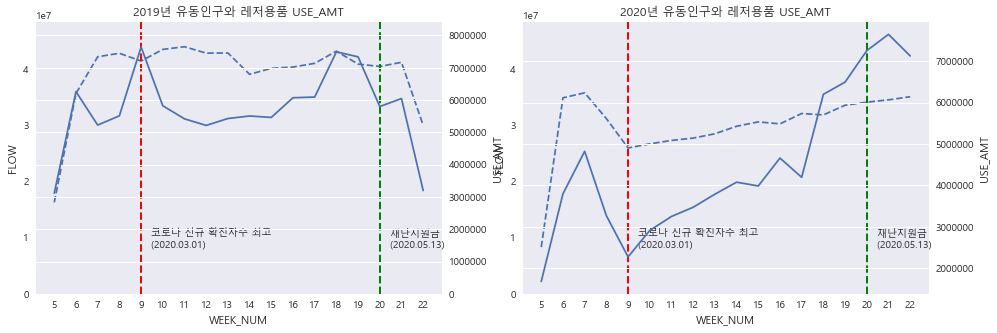

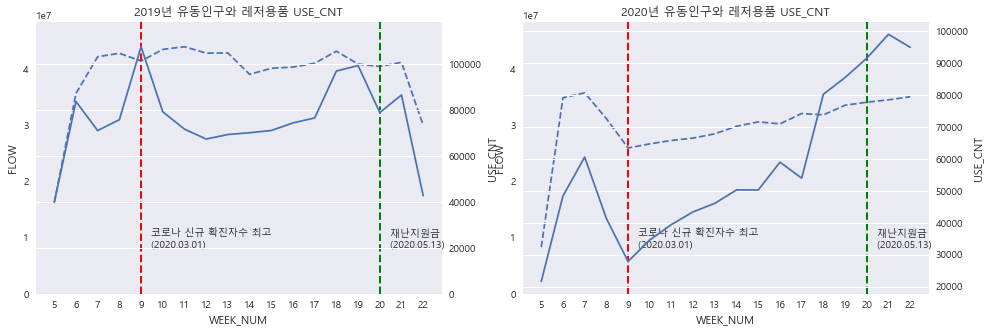

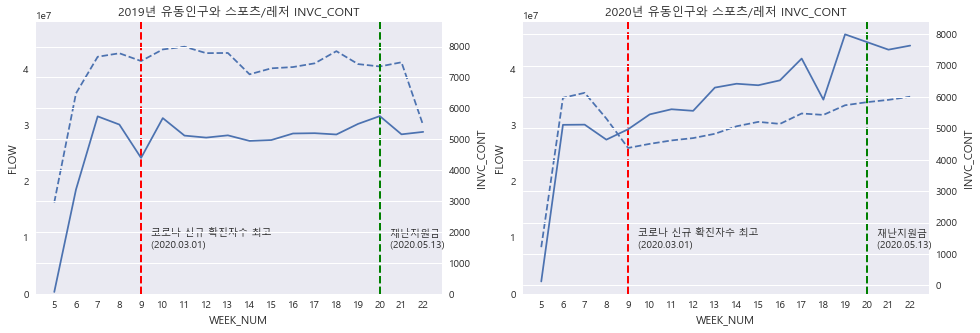

In [38]:
graph_flow_and_onoff(offline, "레저용품", "MCT_CAT_CD", "USE_AMT")
graph_flow_and_onoff(offline, "레저용품", "MCT_CAT_CD", "USE_CNT")
graph_flow_and_onoff(online, "스포츠/레저", "DL_GD_LCLS_NM", "INVC_CONT")

### 3) 성별 유동인구와 USE_AMT 시각화

In [39]:
#dataframe, category_name, aggregate_column, flow_dong_column, onoff_dong_column, category_column, return_option=False

dataframe = offline
category_name = "레저용품"
aggregate_column = "USE_AMT"
category_column = "MCT_CAT_CD"
flow_hue_column = 'SEX_CD'
onoff_hue_column = "SEX_CD"

In [40]:
def graph_flow_and_onoff_by_hue(offline_or_online_data, category_name, category_column, aggregate_column, flow_hue_column, onoff_hue_column):
    # 데이터 꺼내기
    onoffline_category = offline_or_online_data.query('{}=="{}"'.format(category_column, category_name))
    onoffline_category = onoffline_category.groupby([category_column, onoff_hue_column, 'YEAR', 'WEEK_NUM'])[[aggregate_column]].mean().reset_index()
    flow_category = flow.groupby([flow_hue_column, 'YEAR', 'WEEK_NUM'])[['FLOW']].mean().reset_index()
    
    # 변수
    max_date_num_week = 9 # 신규확진자 최고 등장 주
    disaster_support_date_num_week = 20 # 재난지원금 지급 시작 주
    HUEs = onoffline_category[onoff_hue_column].unique()
    
    fig, axes = plt.subplots(nrows=2, figsize=(18, 10))
    sns.lineplot(x='WEEK_NUM', y='FLOW', data=flow_category.query('YEAR==2019'), hue=flow_hue_column, ax=axes[0])
    sns.lineplot(x='WEEK_NUM', y='FLOW', data=flow_category.query('YEAR==2020'), hue=flow_hue_column, ax=axes[0])    
    sns.lineplot(x='WEEK_NUM', y=aggregate_column, data=onoffline_category.query('YEAR==2019'), hue=onoff_hue_column, ax=axes[1])
    sns.lineplot(x='WEEK_NUM', y=aggregate_column, data=onoffline_category.query('YEAR==2020'), hue=onoff_hue_column, ax=axes[1])
    
    for i in range(len(set(onoffline_category[onoff_hue_column]))):
        axes[0].lines[i].set_linestyle("--")
        axes[1].lines[i].set_linestyle("--")
    
    axes[0].set_ylim([0, flow_category['FLOW'].max()*1.1])
    axes[1].set_ylim([0, onoffline_category[aggregate_column].max()*1.1])
    axes[0].set_xticks([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
    axes[1].set_xticks([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
    axes[0].set_title("유동인구" + "  (dotted: 2019, line: 2020)", fontsize=14)
    axes[1].set_title(aggregate_column + "  (dotted: 2019, line: 2020)", fontsize=14)
    
    # 시각화
    fig, axes = plt.subplots(nrows=len(HUEs), ncols=2, figsize=(20, 6*len(HUEs)))
    axes_twinx = [[axes[i][0].twinx(), axes[i][1].twinx()] for i in range(len(HUEs))]
    print("\n\n점선: 유동인구 / 실선: {}".format(aggregate_column))
    for i, hue in enumerate(HUEs):
        onoff_temp = onoffline_category.loc[onoffline_category[onoff_hue_column]==hue, :]
        flow_temp = flow_category.loc[flow_category[flow_hue_column]==hue, :]
        sns.lineplot(x='WEEK_NUM', y='FLOW', 
                     data=flow_temp.loc[(flow_temp['YEAR']==2019) & (flow_temp[flow_hue_column]==hue), :], ax=axes[i][0])
        sns.lineplot(x='WEEK_NUM', y='FLOW', 
                     data=flow_temp.loc[(flow_temp['YEAR']==2020) & (flow_temp[flow_hue_column]==hue), :], ax=axes[i][1])
        sns.lineplot(x='WEEK_NUM', y=aggregate_column, 
                     data=onoff_temp.loc[(onoff_temp['YEAR']==2019) & (onoff_temp[onoff_hue_column]==hue), :], ax=axes_twinx[i][0])
        sns.lineplot(x='WEEK_NUM', y=aggregate_column, 
                     data=onoff_temp.loc[(onoff_temp['YEAR']==2020) & (onoff_temp[onoff_hue_column]==hue), :], ax=axes_twinx[i][1])

        years = [2019, 2020]
        for j in [0, 1]:
            axes[i][j].lines[0].set_linestyle("--")
            axes[i][j].set_ylim([0, flow_temp['FLOW'].max()*1.1])
            axes_twinx[i][j].set_ylim([0, onoff_temp[aggregate_column].max()*1.1])
            axes[i][j].grid(False)
            axes[i][j].set_xticks([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
            axes[i][j].axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
            axes[i][j].axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
            axes[i][j].text(x=max_date_num_week, y=0, fontsize=10, 
                            s='　코로나 신규 확진자수 최고\n　(2020.03.01)')
            axes[i][j].text(x=disaster_support_date_num_week, y=0, fontsize=10,
                            s='　재난지원금\n　(2020.05.13)')
            axes[i][j].set_title("{}년 유동인구와 {} {} : {}".format(years[j], category_name, aggregate_column, hue), fontsize=13)



점선: 유동인구 / 실선: USE_AMT


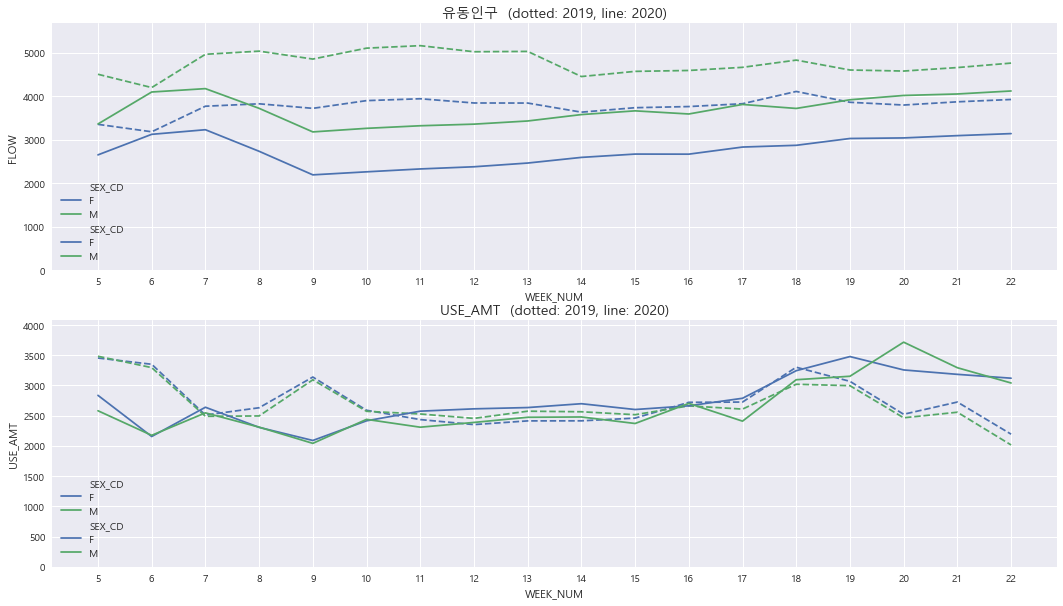

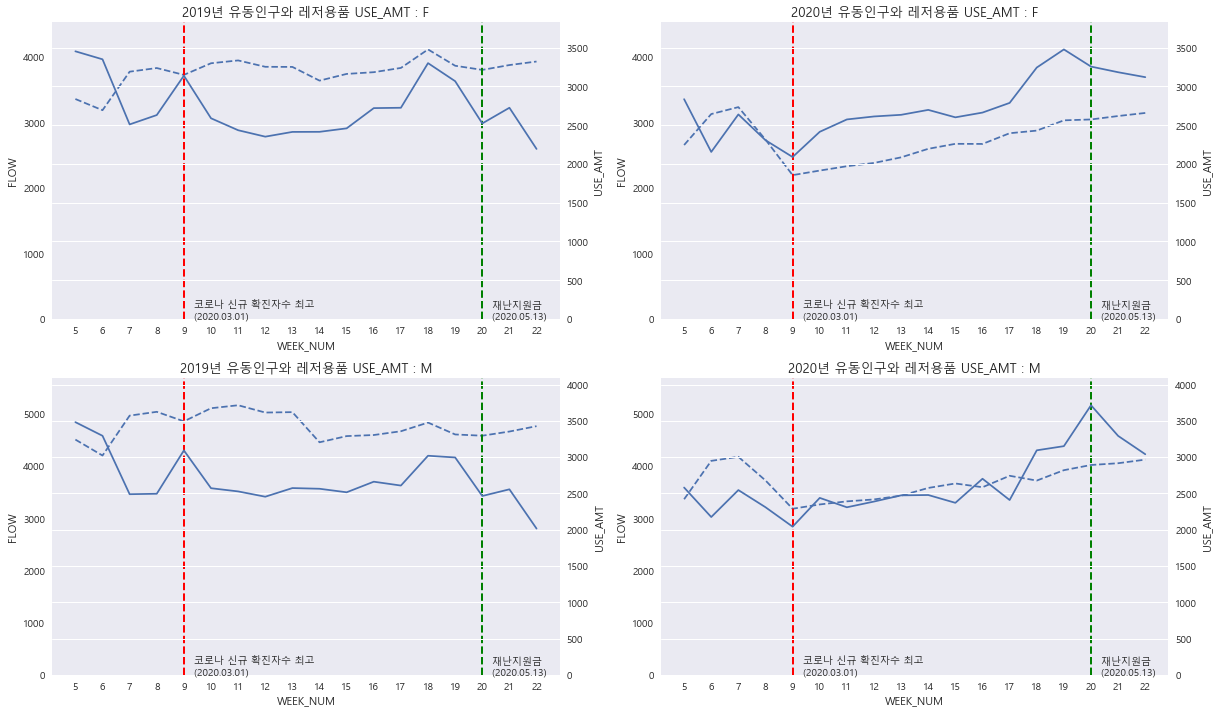

In [41]:
graph_flow_and_onoff_by_hue(offline, "레저용품", "MCT_CAT_CD", "USE_AMT", 'SEX_CD', 'SEX_CD')